In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

In [2]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

model = torch.nn.Sequential(*list(resnet_model.children())[:-1]).to('cpu')
model.eval()

for param in model.parameters():
    param.requires_grad = False

del resnet_model

In [3]:
transform = ResNet50_Weights.DEFAULT.transforms()

In [4]:
class_labels = []
y_true = []
resnet_features = []

for classes in ['color','good','cut','hole','metal_contamination','thread']:
    folder_path = Path(r'carpet\test\{}'.format(classes))

    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).to('cpu').unsqueeze(0)
            features = model(test_image)
            resnet_features.append(features.squeeze().cpu().detach().numpy())

        class_labels.append(class_label)
        y_true.append(0 if class_label == 'good' else 1)

resnet_features = np.array(resnet_features)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

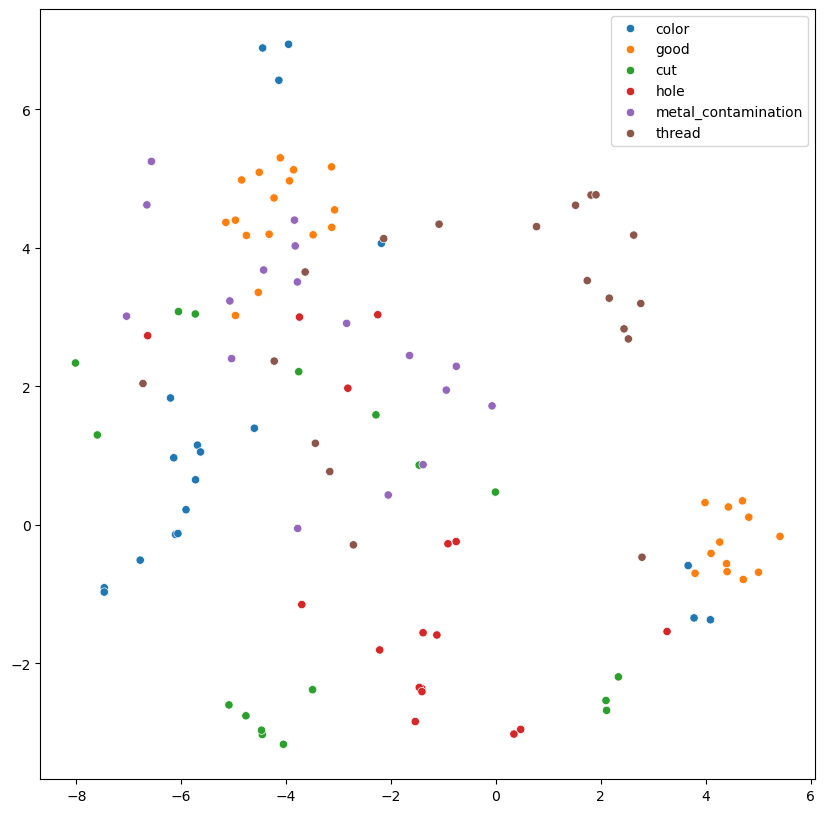

In [5]:
from sklearn.manifold import TSNE
# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
resnet_features_2d = tsne.fit_transform(resnet_features)

plt.figure(figsize=(10,10))
sns.scatterplot(x=resnet_features_2d[:,0],y=resnet_features_2d[:,1],hue=class_labels)
plt.show()

In [6]:
memory_bank =[]

folder_path = Path(r'carpet\train\good')

for pth in tqdm(folder_path.iterdir(),leave=False):

    with torch.no_grad():
        data = transform(Image.open(pth)).to('cpu').unsqueeze(0)
        features = model(data)
        memory_bank.append(features.squeeze().cpu().detach())

memory_bank = torch.stack(memory_bank).to('cpu')


0it [00:00, ?it/s]

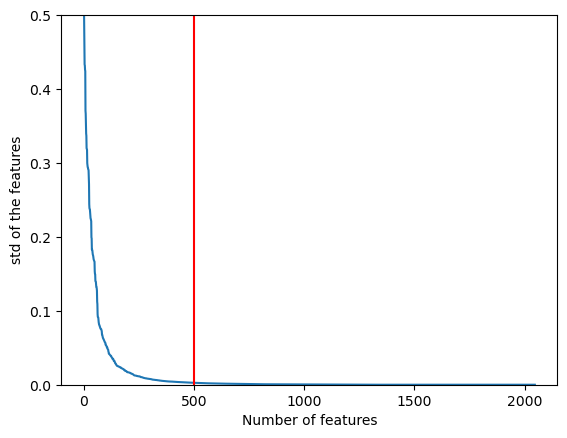

In [7]:
values,indices = torch.sort(memory_bank.std(dim=0))

plt.plot(values.cpu().numpy()[::-1])
plt.vlines(x=500,ymin=0,ymax=0.5,colors='red')
plt.ylim([0,0.5])
plt.ylabel("std of the features")
plt.xlabel("Number of features")
plt.show()

In [8]:
values,indices = torch.sort(memory_bank.std(dim=0))
selected_indices = indices[-500:]
memory_bank = memory_bank[:,selected_indices]

In [9]:
memory_bank.shape

torch.Size([280, 500])

In [10]:
y_score=[]

k=50

folder_path = Path(r'carpet\train\good')

for pth in tqdm(folder_path.iterdir(),leave=False):
    data = transform(Image.open(pth)).to('cpu').unsqueeze(0)
    with torch.no_grad():
        features = model(data).squeeze()
    dist,_=torch.sort(torch.norm(memory_bank - features[selected_indices], dim=1))# Calculating the pair-wise distance between the sample and memory bank
    dist = dist[:k].mean()# K nearsest neighbours
    y_score.append(dist.cpu().numpy())

0it [00:00, ?it/s]

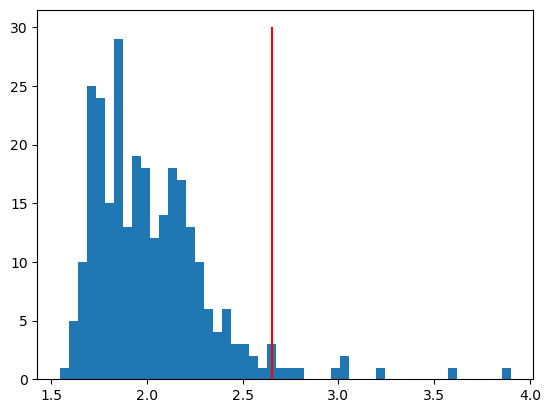

In [11]:
best_threshold = np.mean(y_score) + 2 * np.std(y_score)

plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

In [12]:
folder_path = Path(r'carpet\test\color')

class_labels = []
y_true = []
resnet_features = []
y_score = []

for classes in ['color','good','cut','hole','metal_contamination','thread']:
    folder_path = Path(r'carpet\test\{}'.format(classes))

    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).to('cpu').unsqueeze(0)
            features = model(test_image).squeeze()    
            dist,_=torch.sort(torch.norm(memory_bank - features[selected_indices], dim=1))#[-10:].mean()
            dist = dist[:k].mean()
            y_score.append(dist.cpu().numpy())

        class_labels.append(class_label)
        y_true.append(0 if class_label == 'good' else 1)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

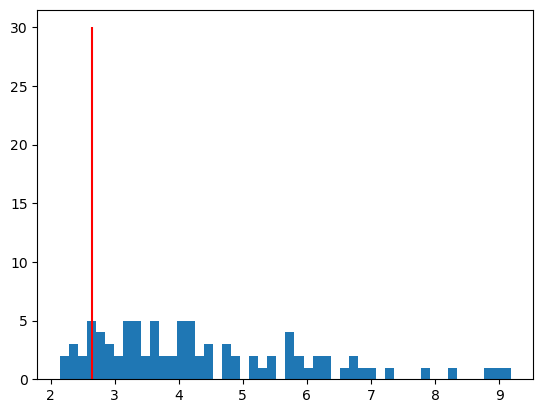

In [13]:
y_score_nok = [score  for score,true in zip(y_score,y_true) if true==1]
plt.hist(y_score_nok,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

AUC-ROC Score: 0.7403691813804174


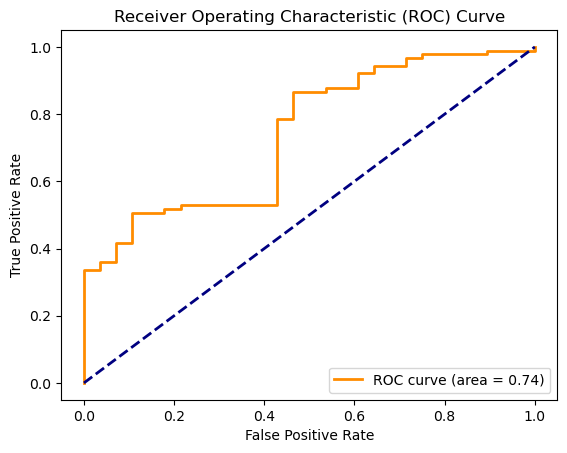

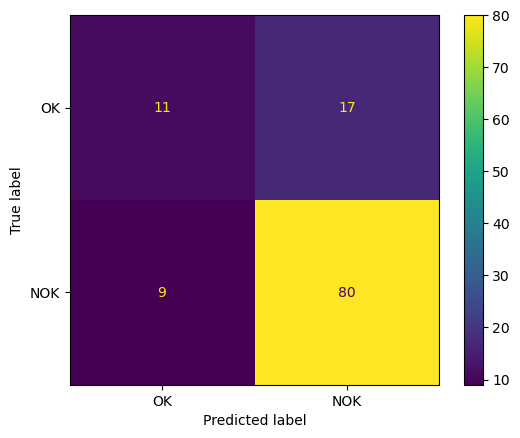

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score


# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()